In [1]:
import pandas as pd
import numpy as np

In [2]:
df_1 = pd.read_csv("homework_4.1.csv")
df_1.head(5)

,Unnamed: 0,Z,W,X,Y
0,0,0,-0.155644,-0.496971,0.282484
1,1,1,0.529539,2.284240,4.740596
2,2,1,0.910514,0.872232,3.449569
3,3,1,-0.705476,2.157260,3.002531
4,4,0,-0.590874,-0.386730,-1.848796


In [3]:
df_1["W_bin"] = pd.qcut(df_1["W"], q = 10)
effects = []

for w_bin, group in df_1.groupby("W_bin"):
    group_z1 = group[group["Z"] == 1]
    group_z0 = group[group["Z"] == 0]

    y_diff = group_z1["Y"].mean() - group_z0["Y"].mean()
    x_diff = group_z1["X"].mean() - group_z0["X"].mean()

    if x_diff == 0:
        continue
    effects.append(y_diff / x_diff)

instumental_effect = np.mean(effects)
print(instumental_effect)

1.5088963715407195


/tmp/ipykernel_4700/3927276752.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for w_bin, group in df_1.groupby("W_bin"):


In [4]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [5]:
df_a = pd.read_csv("homework_4.2.a.csv")
df_b = pd.read_csv("homework_4.2.b.csv")

In [6]:
df_a.head(5)

,Unnamed: 0,X,Y
0,0,81.822339,1
1,1,92.487870,0
2,2,85.372460,0
3,3,78.828025,0
4,4,75.807080,1


In [7]:
df_b.head(5)

,Unnamed: 0,X2,Y2
0,0,76.643034,1
1,1,87.743397,1
2,2,81.639469,1
3,3,73.740485,0
4,4,90.480268,1


RDD for Dataset A - Estimated jump at cutoff: 0.295
RDD for Dataset B - Estimated jump at cutoff: 0.198


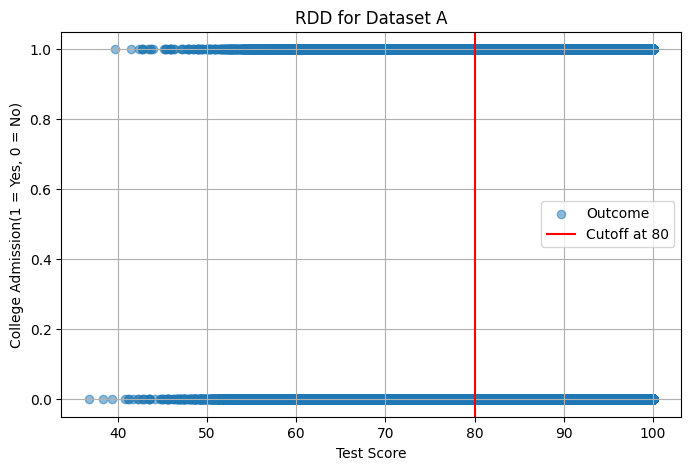

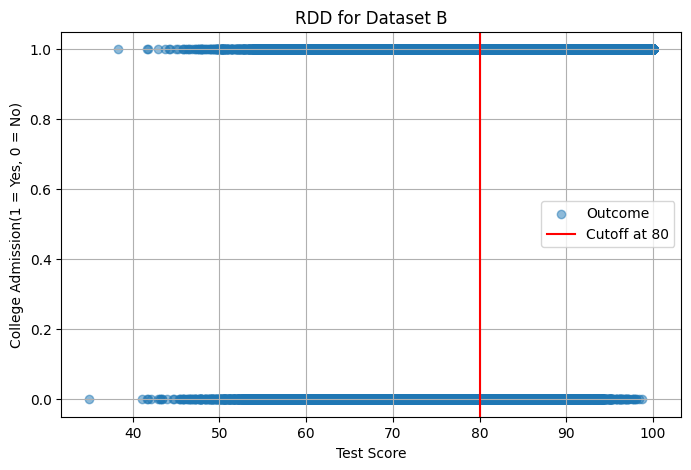

In [8]:
def analyze_rdd(df, x_col, y_col, cutoff = 80, window = 10, title = "RDD Plot"):
    df = df.sort_values(by=x_col)

    plt.figure(figsize=(8,5))
    plt.scatter(df[[x_col]], df[y_col], alpha= 0.5, label = "Outcome")
    plt.axvline(cutoff, color = "red", linestyle = "-", label = f"Cutoff at {cutoff}")
    plt.xlabel("Test Score")
    plt.ylabel("College Admission(1 = Yes, 0 = No)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show

    left = df[(df[x_col] >= cutoff - window) & (df[x_col] < cutoff)]
    right = df[(df[x_col] <= cutoff + window) & (df[x_col] >= cutoff)]

    left_x = sm.add_constant(left[x_col])
    right_x = sm.add_constant(right[x_col])

    left_model = sm.OLS(left[y_col], left_x).fit()
    right_model = sm.OLS(right[y_col], right_x).fit()

    y_left = left_model.predict([1, cutoff])[0]
    y_right = right_model.predict([1, cutoff])[0]

    jump = y_right - y_left
    print(f"{title} - Estimated jump at cutoff: {jump:.3f}")
    return jump

jump_a = analyze_rdd(df_a, "X", "Y", cutoff = 80, title="RDD for Dataset A")
jump_b = analyze_rdd(df_b, "X2", "Y2", cutoff = 80, title="RDD for Dataset B")

In [9]:
def check_slope_before_cutoff(df, x_col, y_col, cutoff=80, label="Dataset"):
   
    df_left = df[df[x_col] < cutoff]
    
   
    X = sm.add_constant(df_left[x_col])
    y = df_left[y_col]
    
   
    model = sm.OLS(y, X).fit()
    
    slope = model.params[x_col]
    print(f"{label} - Slope before cutoff: {slope:.4f}")
    if slope > 0:
        print(f" {label}: Y is increasing before the cutoff.\n")
    else:
        print(f" {label}: Y is decreasing before the cutoff.\n")


check_slope_before_cutoff(df_a, "X", "Y", label="Dataset A")
check_slope_before_cutoff(df_b, "X2", "Y2", label="Dataset B")

Dataset A - Slope before cutoff: 0.0002
 Dataset A: Y is increasing before the cutoff.

Dataset B - Slope before cutoff: 0.0102
 Dataset B: Y is increasing before the cutoff.



In [10]:
from sklearn.linear_model import LogisticRegression

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


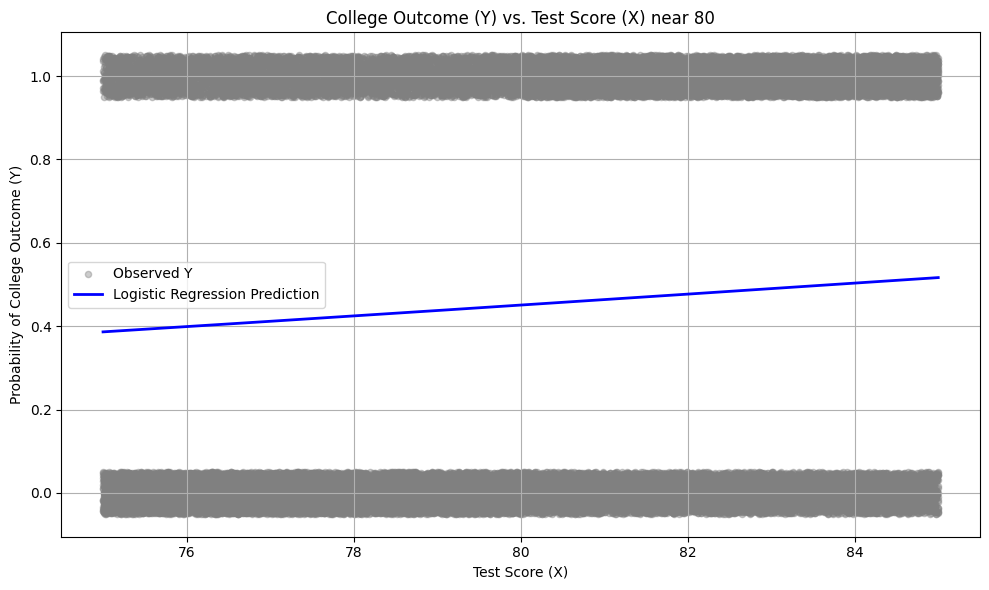

In [11]:
df = pd.concat([df_a, df_b], ignore_index=True)

df_clean = df[["X", "Y"]].dropna()

df_near_80 = df_clean[(df_clean["X"] >= 75) & (df_clean["X"] <= 85)]

model = LogisticRegression()
X_train = df_clean[["X"]]
y_train = df_clean["Y"]
model.fit(X_train, y_train)

X_plot = np.linspace(75, 85, 300).reshape(-1, 1)
y_prob = model.predict_proba(X_plot)[:, 1]

plt.figure(figsize=(10, 6))

plt.scatter(df_near_80["X"], df_near_80["Y"] + np.random.uniform(-0.05, 0.05, len(df_near_80)),
            alpha=0.4, label="Observed Y", color="gray", s=20)

plt.plot(X_plot, y_prob, color="blue", linewidth=2, label="Logistic Regression Prediction")

plt.title("College Outcome (Y) vs. Test Score (X) near 80")
plt.xlabel("Test Score (X)")
plt.ylabel("Probability of College Outcome (Y)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [13]:
df_a_clean = df_a[["X", "Y"]].dropna()
df_b_clean = df_b[["X2", "Y2"]].rename(columns={"X2": "X", "Y2": "Y"}).dropna()

def linear_fit_r2(df, cutoff=80):
    before = df[df["X"] < cutoff]
    after = df[df["X"] >= cutoff]
    
    model_before = LinearRegression().fit(before[["X"]], before["Y"])
    r2_before = r2_score(before["Y"], model_before.predict(before[["X"]]))
    
    model_after = LinearRegression().fit(after[["X"]], after["Y"])
    r2_after = r2_score(after["Y"], model_after.predict(after[["X"]]))
    
    return r2_before, r2_after


r2_a = linear_fit_r2(df_a_clean)
r2_b = linear_fit_r2(df_b_clean)


print("Dataset A - R² before 80:", r2_a[0], "| R² after 80:", r2_a[1])
print("Dataset B - R² before 80:", r2_b[0], "| R² after 80:", r2_b[1])

Dataset A - R² before 80: 8.623788795736331e-06 | R² after 80: 3.357626731315122e-06
Dataset B - R² before 80: 0.016161139360566512 | R² after 80: 0.013428593795585253


In [14]:
def get_slopes(df, cutoff=80):
    before = df[df["X"] < cutoff]
    after = df[df["X"] >= cutoff]
    
    model_before = LinearRegression().fit(before[["X"]], before["Y"])
    model_after = LinearRegression().fit(after[["X"]], after["Y"])
    
    slope_before = model_before.coef_[0]
    slope_after = model_after.coef_[0]
    
    return slope_before, slope_after

# Compute slopes
slope_a = get_slopes(df_a_clean)
slope_b = get_slopes(df_b_clean)

In [15]:
slope_a

(np.float64(0.00022383079703675504), np.float64(0.00016108686482244668))

In [16]:
slope_b

(np.float64(0.010216711274456712), np.float64(0.0050086140682367546))

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


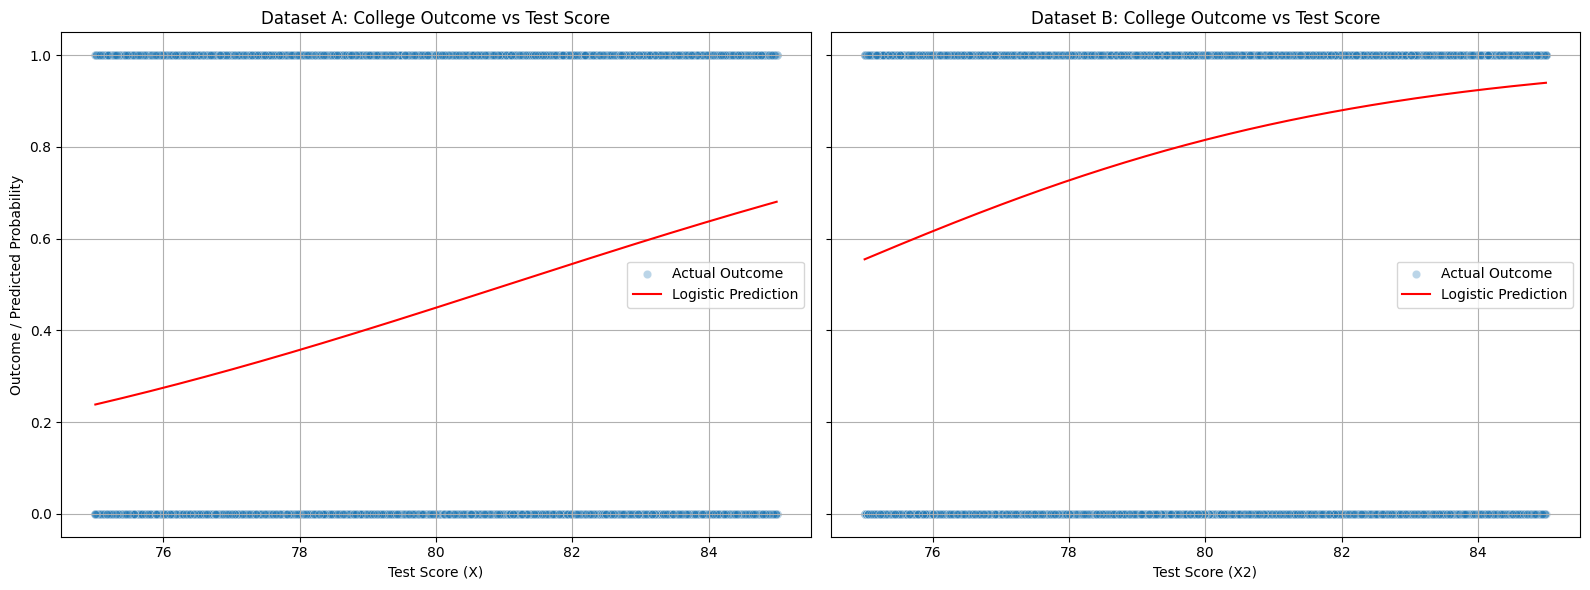

In [ ]:
import seaborn as sns
df_a = pd.read_csv("homework_4.2.a.csv")
df_b = pd.read_csv("homework_4.2.b.csv")


df_a_filtered = df_a[(df_a['X'] >= 75) & (df_a['X'] <= 85)]
df_b_filtered = df_b[(df_b['X2'] >= 75) & (df_b['X2'] <= 85)]

model_a = LogisticRegression()
X_a = df_a_filtered[['X']]
y_a = df_a_filtered['Y']
model_a.fit(X_a, y_a)
x_range_a = np.linspace(75, 85, 200).reshape(-1, 1)
y_probs_a = model_a.predict_proba(x_range_a)[:, 1]

model_b = LogisticRegression()
X_b = df_b_filtered[['X2']]
y_b = df_b_filtered['Y2']
model_b.fit(X_b, y_b)
x_range_b = np.linspace(75, 85, 200).reshape(-1, 1)
y_probs_b = model_b.predict_proba(x_range_b)[:, 1]


fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot A
sns.scatterplot(ax=axs[0], x='X', y='Y', data=df_a_filtered, alpha=0.3, label='Actual Outcome')
sns.lineplot(ax=axs[0], x=x_range_a.flatten(), y=y_probs_a, color='red', label='Logistic Prediction')
axs[0].set_title("Dataset A: College Outcome vs Test Score")
axs[0].set_xlabel("Test Score (X)")
axs[0].set_ylabel("Outcome / Predicted Probability")
axs[0].grid(True)

# Plot B
sns.scatterplot(ax=axs[1], x='X2', y='Y2', data=df_b_filtered, alpha=0.3, label='Actual Outcome')
sns.lineplot(ax=axs[1], x=x_range_b.flatten(), y=y_probs_b, color='red', label='Logistic Prediction')
axs[1].set_title("Dataset B: College Outcome vs Test Score")
axs[1].set_xlabel("Test Score (X2)")
axs[1].grid(True)

plt.tight_layout()
plt.show()
